# Joint Multi Wind Farm Optimization

TopFarm is capable of doing a joint optimization over multiple wind farms at once. This way we can define multiple boundaries assigned to a cluster of turbines, seperating them into blocks.

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

Import required modules

In [2]:
from enum import Enum
import numpy as np
import topfarm
import matplotlib.pyplot as plt
from topfarm import TopFarmProblem
from topfarm.constraint_components.boundary import MultiCircleBoundaryConstraint
from topfarm.constraint_components.boundary import (
    MultiXYBoundaryConstraint,
    Boundary,
)
from topfarm.constraint_components.constraint_aggregation import (
    DistanceConstraintAggregation,
)
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.py_wake_wrapper import (
    PyWakeAEPCostModelComponent,
)
from topfarm.easy_drivers import EasyScipyOptimizeDriver, EasySGDDriver
from topfarm.plotting import XYPlotComp
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.utils.gradients import autograd
from py_wake.validation.lillgrund import LillgrundSite
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
from topfarm.cost_models.cost_model_wrappers import AEPCostModelComponent

PyWake model setup

In [3]:
wind_turbines = GenericWindTurbine("GenWT", 100.6, 2000, 150)
site = LillgrundSite()
wf_model = Bastankhah_PorteAgel_2014(
    site,
    wind_turbines,
    k=0.0324555,  # default value from BastankhahGaussianDeficit
)

Generate initial layout. With variable `grid_side` you can adjust how many turbines each boundary has i.e. $N_{wt} = size_{grid}^2 * N_{boundaries} = size_{grid}^2 * 3$

Initial layout has 12 wind turbines


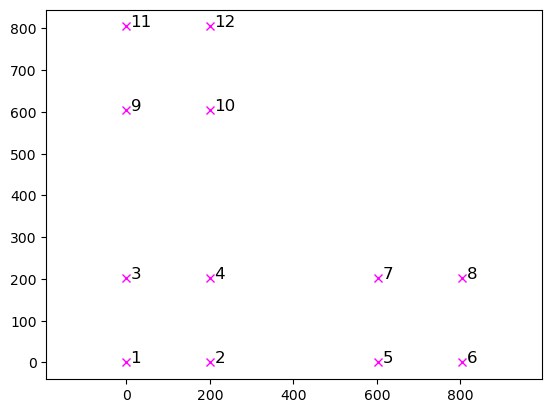

In [4]:
# generate initial positions
grid_size = 2
wt_x1, wt_y1 = np.meshgrid(
    np.linspace(0, wind_turbines.diameter() * grid_size, grid_size),
    np.linspace(0, wind_turbines.diameter() * grid_size, grid_size),
)
wt_x1, wt_y1 = wt_x1.flatten(), wt_y1.flatten()
wt_x2 = wt_x1 + wind_turbines.diameter() * grid_size * 3.0
wt_y2 = wt_y1
wt_y3 = wt_y1 + wind_turbines.diameter() * grid_size * 3.0
wt_x3 = wt_x1
X_full = np.concatenate([wt_x1, wt_x2, wt_x3])
Y_full = np.concatenate([wt_y1, wt_y2, wt_y3])
n_wt = len(X_full)
print(f"Initial layout has {n_wt} wind turbines")

# plot initial layout
plt.figure()
plt.plot(X_full, Y_full, "x", c="magenta")
# put indeces on the wind turbines
for i in range(n_wt):
    plt.text(X_full[i] + 10, Y_full[i], str(i + 1), fontsize=12)
plt.axis("equal")
plt.show()

Create masks designating which turbines are assigned to which farm

In [5]:
n_wt_sf = n_wt // 3
wf1_mask = np.zeros(n_wt, dtype=bool)
wf1_mask[:n_wt_sf] = True
wf2_mask = np.zeros(n_wt, dtype=bool)
wf2_mask[n_wt_sf : n_wt_sf * 2] = True
wf3_mask = ~(wf1_mask | wf2_mask)  # the rest of turbines

print(f"Turbines belonging to wind farm 1: {np.where(wf1_mask)[0]}")
print(f"Turbines belonging to wind farm 2: {np.where(wf2_mask)[0]}")
print(f"Turbines belonging to wind farm 3: {np.where(wf3_mask)[0]}")

Turbines belonging to wind farm 1: [0 1 2 3]
Turbines belonging to wind farm 2: [4 5 6 7]
Turbines belonging to wind farm 3: [ 8  9 10 11]


Construct a constraint object from the masks and initial layouts. You can choose which type of constraint to create from available enum options in ConstraintType. There are two options: circular or convex hull constraint. You can change `constr_type` variable and run optimization once more with different constaint type.

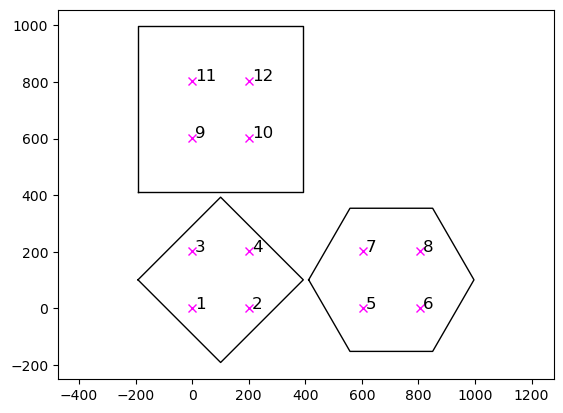

In [6]:
class ConstraintType(Enum):  # fmt: skip
    circular = 0
    convex_hull = 1
constr_type = ConstraintType.convex_hull  # or ConstraintType.circular

# utility functions to construct the boundary constraint
def _get_radius(x, y):  # fmt: skip
    return np.sqrt((x - x.mean()) ** 2 + (y - y.mean()) ** 2).max() + 100
def _get_center(x, y):  # fmt: skip
    return np.array([x.mean(), y.mean()])
def _get_corners(x: np.ndarray, y: np.ndarray, radius, stype='rect'):  # fmt: skip
    cx = x.mean()
    cy = y.mean()
    if stype == "rect":
        return np.array(
            [
                [cx + radius, cy + radius],
                [cx - radius, cy - radius],
                [cx + radius, cy - radius],
                [cx - radius, cy + radius],
            ]
        )
    if stype == "rot":
        return np.array(
            [
                [cx, cy + radius],
                [cx + radius, cy],
                [cx, cy - radius],
                [cx - radius, cy],
            ]
        )
    if stype == "hex":
        return np.array(
            [
                [cx + radius, cy],
                [cx + radius / 2, cy + radius * np.sqrt(3) / 2],
                [cx - radius / 2, cy + radius * np.sqrt(3) / 2],
                [cx - radius, cy],
                [cx - radius / 2, cy - radius * np.sqrt(3) / 2],
                [cx + radius / 2, cy - radius * np.sqrt(3) / 2],
            ]
        )
    raise ValueError(f"Unknown shape type: {stype}")

if constr_type == ConstraintType.circular:
    constraint_comp = MultiCircleBoundaryConstraint(
        center=[
            _get_center(wt_x1, wt_y1),
            _get_center(wt_x2, wt_y2),
            _get_center(wt_x3, wt_y3),
        ],
        radius=[
            _get_radius(wt_x1, wt_y1),
            _get_radius(wt_x2, wt_y2),
            _get_radius(wt_x3, wt_y3),
        ],
        masks=[wf1_mask, wf2_mask, wf3_mask],
    )
elif constr_type == ConstraintType.convex_hull:
    radius = (
        np.sqrt((wt_x1 - wt_x1.mean()) ** 2 + (wt_y1 - wt_y1.mean()) ** 2).max() + 150
    )
    wf1_corners = _get_corners(wt_x1, wt_y1, radius, stype="rot")
    wf2_corners = _get_corners(wt_x2, wt_y2, radius, stype="hex")
    wf3_corners = _get_corners(wt_x3, wt_y3, radius, stype="rect")
    constraint_comp = MultiXYBoundaryConstraint(
        [
            Boundary(wf1_corners, design_var_mask=wf1_mask),
            Boundary(wf2_corners, design_var_mask=wf2_mask),
            Boundary(wf3_corners, design_var_mask=wf3_mask),
        ],
        boundary_type="convex_hull",
    )
else:
    raise ValueError(f"Unknown constraint type: {constr_type}")

# let's see how the boundaries look like
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(X_full, Y_full, "x", c="magenta")
for i in range(n_wt):
    plt.text(X_full[i] + 10, Y_full[i], str(i + 1), fontsize=12)
plt.axis("equal")
constraint_comp.get_comp(n_wt).plot(ax1)
plt.show()

Setup cost model based on PyWake AEP. There are two different options here, to be used with Stohastic Gradient Decent (SGD) or Sequential Least Squares Programming (SLSQP) optimization algorithms. Due to stochastic nature of SGD one can sample part of the full wind speeds and directions and compute AEP on partial observations.

In [7]:
np.random.seed(42)
# Wind Resouces
full_wd = np.arange(0, 360, 1)  # wind directions
full_ws = np.arange(3, 25, 1)  # wind speeds
freqs = site.local_wind(  # sector frequencies
    X_full,
    Y_full,
    wd=full_wd,
    ws=full_ws,
).Sector_frequency_ilk[0, :, 0]
# weibull parameters
As = site.local_wind(X_full, Y_full, wd=full_wd, ws=full_ws).Weibull_A_ilk[0, :, 0]
ks = site.local_wind(X_full, Y_full, wd=full_wd, ws=full_ws).Weibull_k_ilk[0, :, 0]
N_SAMPLES = 25  # play with the number of samples


# sample wind resources
def wind_resource_sample():
    idx = np.random.choice(np.arange(full_wd.size), N_SAMPLES, p=freqs / freqs.sum())
    wd = full_wd[idx]
    ws = As[idx] * np.random.weibull(ks[idx])
    return wd, ws


# aep function - SGD
def aep_func(x, y, full=False, **kwargs):
    wd, ws = wind_resource_sample() if not full else (full_wd, full_ws)
    aep_sgd = wf_model(x, y, wd=wd, ws=ws, time=not full).aep().sum().values * 1e6
    return aep_sgd


# gradient function - SGD
def aep_jac(x, y, **kwargs):
    wd, ws = wind_resource_sample()
    jx, jy = wf_model.aep_gradients(
        gradient_method=autograd, wrt_arg=["x", "y"], x=x, y=y, ws=ws, wd=wd, time=True
    )
    daep_sgd = np.array([np.atleast_2d(jx), np.atleast_2d(jy)]) * 1e6
    return daep_sgd


# AEP Cost Model Component - SGD
sgd_cost_comp = AEPCostModelComponent(
    input_keys=[topfarm.x_key, topfarm.y_key],
    n_wt=n_wt,
    cost_function=aep_func,
    cost_gradient_function=aep_jac,
)

# AEP Cost Model Component - SLSQP
slsqp_cost_comp = PyWakeAEPCostModelComponent(
    windFarmModel=wf_model, n_wt=n_wt, grad_method=autograd
)

Setup a driver to be used in optimization. You can try running with either of SLSQP or SGD by changing the driver type.

In [8]:
driver_type = "SLSQP"  # "SLSQP" or "SGD"
min_spacing = wind_turbines.diameter() * 2

if driver_type == "SLSQP":
    constraints = [
        constraint_comp,
        SpacingConstraint(min_spacing=min_spacing),
    ]
    driver = EasyScipyOptimizeDriver(
        optimizer="SLSQP",
        # might not be enough for the optimizer to converge
        maxiter=200,
    )
    cost_comp = slsqp_cost_comp
elif driver_type == "SGD":
    constraints = DistanceConstraintAggregation(
        [
            SpacingConstraint(min_spacing=min_spacing),
            constraint_comp,
        ],
        n_wt=n_wt,
        min_spacing_m=min_spacing,
        windTurbines=wind_turbines,
    )
    driver = EasySGDDriver(
        # might not be enough for the optimizer to converge
        maxiter=200,
        speedupSGD=True,
        learning_rate=wind_turbines.diameter() / 5,
        gamma_min_factor=0.1,
    )
    cost_comp = sgd_cost_comp
else:
    raise ValueError(f"Unknown driver: {driver_type}")

Setup TopFarmProblem object and run the optimization. 

Due to sampling in the SGD AEP computation the final AEP result in the plot will not reflect the actual improvement in AEP. Thus it is necessary to compute AEP boost later on in the notebook.

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


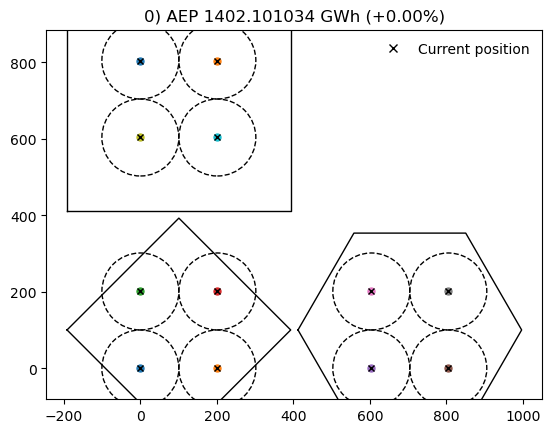

Iteration limit reached    (Exit mode 9)
            Current function value: -1428.2027728744797
            Iterations: 200
            Function evaluations: 220
            Gradient evaluations: 200
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	30.800s


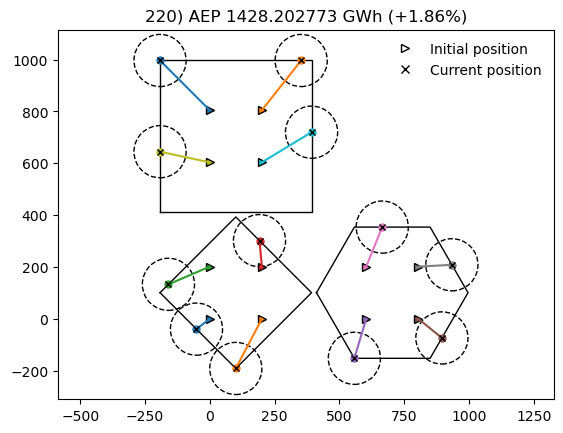

In [9]:
problem = TopFarmProblem(
    design_vars={"x": X_full, "y": Y_full},
    n_wt=n_wt,
    constraints=constraints,
    cost_comp=cost_comp,
    driver=driver,
    plot_comp=XYPlotComp(),
)

cost, state, recorder = problem.optimize(disp=True)

In [10]:
initial_aep = aep_func(recorder["x"][0], recorder["y"][0], full=True)
final_aep = aep_func(recorder["x"][-1], recorder["y"][-1], full=True)
print(f"AEP relative improvement: {(final_aep - initial_aep) / initial_aep * 100:.2f}%")

AEP relative improvement: 1.86%


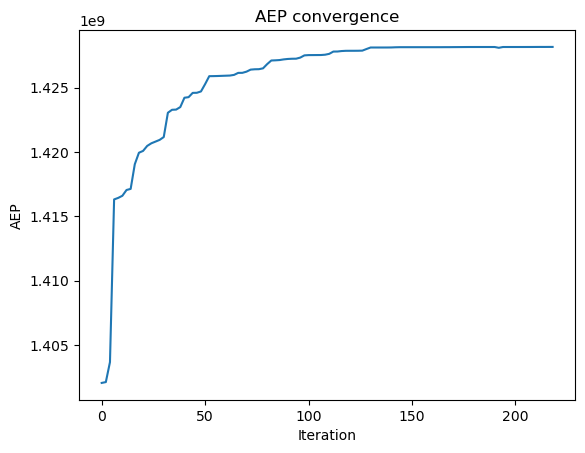

In [11]:
aeps = []
iterations = range(len(recorder["x"]))
for i in iterations:
    if i % 2 == 0:
        continue
    aeps.append(aep_func(recorder["x"][i], recorder["y"][i], full=True))
plt.figure()
plt.plot(np.arange(0, len(aeps) * 2, 2), aeps)
plt.xlabel("Iteration")
plt.ylabel("AEP")
plt.title("AEP convergence")
plt.show()

### Exercises

1. Play with the optimization/drivers/constraints parameters to arrive at a desired result and convergence. 
2. You can increase the number of turbines at the very top of the notebook and try to solve a bigger problem.

### Non-Convex Boundaries

Below is an example how to setup joint multi wind farm optimization with non-convex boundary constraints.

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


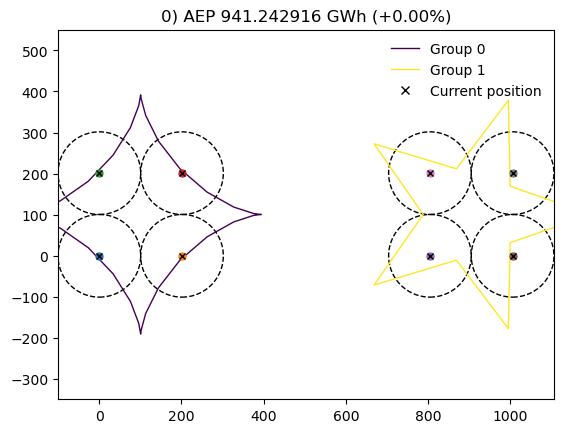

Iteration limit reached    (Exit mode 9)
            Current function value: -948.6739306993165
            Iterations: 100
            Function evaluations: 145
            Gradient evaluations: 100
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	10.325s


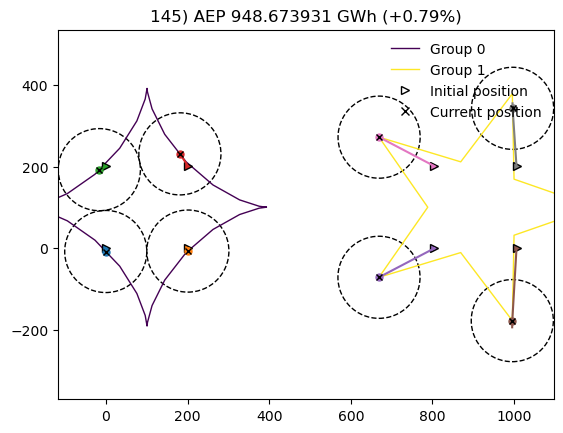

In [12]:
from topfarm.constraint_components.boundary import MultiWFPolygonBoundaryConstraint

wind_turbines = GenericWindTurbine("GenWT", 100.6, 2000, 150)
site = LillgrundSite()
wf_model = Bastankhah_PorteAgel_2014(site, wind_turbines, k=0.0324555)




def _get_astroid_points(cx: float, cy: float, radius: float, num_points: int = 32):
    t = np.linspace(0, 2*np.pi, num_points)
    x = cx + radius * np.cos(t)**3
    y = cy + radius * np.sin(t)**3
    return np.column_stack((x, y))

def _get_star_points(cx: float, cy: float, radius: float, points: int = 5):
    angles = np.linspace(0, 2*np.pi, 2*points, endpoint=False)
    outer_pts = np.array([[cx + radius * np.cos(t), cy + radius * np.sin(t)] 
                         for t in angles[::2]])
    inner_pts = np.array([[cx + (radius*0.4) * np.cos(t), cy + (radius*0.4) * np.sin(t)] 
                         for t in angles[1::2]])
    points = np.empty((2*points, 2))
    points[::2] = outer_pts
    points[1::2] = inner_pts
    return points

def _get_corners(x: np.ndarray, y: np.ndarray, radius, shape='astroid'):
    """Get corner points for different shapes."""
    cx = x.mean()
    cy = y.mean()
    
    if shape == 'astroid':
        return _get_astroid_points(cx, cy, radius)
    elif shape == 'star':
        return _get_star_points(cx, cy, radius)
    else:
        raise ValueError(f"Unknown shape: {shape}")

grid_side = 2
wt_x, wt_y = np.meshgrid(
    np.linspace(0, wind_turbines.diameter() * grid_side, grid_side),
    np.linspace(0, wind_turbines.diameter() * grid_side, grid_side),
)
wt_x, wt_y = wt_x.flatten(), wt_y.flatten()
radius = np.sqrt((wt_x - wt_x.mean()) ** 2 + (wt_y - wt_y.mean()) ** 2).max() + 150

wt_x2 = wt_x + wind_turbines.diameter() * grid_side * 4.0
wt_y2 = wt_y
X_full = np.concatenate([wt_x, wt_x2])
Y_full = np.concatenate([wt_y, wt_y2])
n_wt = len(X_full)

wf1_corners = _get_corners(wt_x, wt_y, radius, shape='astroid')
wf2_corners = _get_corners(wt_x2, wt_y2, radius, shape='star')


boundary_coords = {
    0: wf1_corners,
    1: wf2_corners,
}
constraint_comp = MultiWFPolygonBoundaryConstraint(
    boundaries=boundary_coords,
    turbine_groups={0: np.arange(n_wt // 2), 1: np.arange(n_wt // 2, n_wt)},
)
cost_comp = PyWakeAEPCostModelComponent(
    windFarmModel=wf_model, n_wt=n_wt, grad_method=autograd
)
problem = TopFarmProblem(
    design_vars={"x": X_full, "y": Y_full},
    n_wt=n_wt,
    constraints=(
        [
            constraint_comp,
            SpacingConstraint(min_spacing=wind_turbines.diameter() * 2),
        ]
    ),
    cost_comp=cost_comp,
    driver=(EasyScipyOptimizeDriver(optimizer="SLSQP", maxiter=100)),
    plot_comp=XYPlotComp(),
)

_, state, recorder = problem.optimize(disp=True)